# synaptic-level delays

In [1]:
import numpy as np
from spikeflow import BPNNModel, IzhikevichNeuronLayer
from spikeflow import Synapse, ComplexSynapseLayer, weights_from_synapses
from spikeflow.drawing_utils.trace_renderers import *

/Applications/Anaconda/anaconda/envs/mlbook/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Create a model layer with 2 neurons in a single layer, with a feed-forward connection to a second layer. Each synapse gets its own delay.

In [2]:
model_input_shape = (3,)

neuron_layer_0 = IzhikevichNeuronLayer.layer_from_tuples('n0', [
    IzhikevichNeuronLayer.C(a=0.030, b=0.2, c=-65.0, d=6.0, t=30.0, v0=0.0),
    IzhikevichNeuronLayer.C(a=0.035, b=0.2, c=-65.0, d=6.0, t=30.0, v0=0.0),
    IzhikevichNeuronLayer.C(a=0.020, b=0.2, c=-65.0, d=6.0, t=30.0, v0=0.0),
])

neuron_layer_1 = IzhikevichNeuronLayer.layer_from_tuples('n1', [
    IzhikevichNeuronLayer.C(a=0.010, b=0.2, c=-65.0, d=6.0, t=30.0, v0=0.0),
    IzhikevichNeuronLayer.C(a=0.015, b=0.2, c=-65.0, d=6.0, t=30.0, v0=0.0)
])

forward_connection = ComplexSynapseLayer('fsyn',
    neuron_layer_0, 
    neuron_layer_1, 
    decay = 0.95, 
    #failure_prob = 0.3,
    #post_synaptic_reset_factor = 0.6,
    delay = np.array([[10, 20], [30, 40], [50, 60]]),
    weights = weights_from_synapses(neuron_layer_0, neuron_layer_1, [
        Synapse(0, 0, 5.0),
        Synapse(1, 0, 10.0),
        Synapse(2, 0, 15.0),
        Synapse(0, 1, 8.0),
        Synapse(1, 1, 10.0),
        Synapse(2, 1, 12.0)
    ])
)

model = BPNNModel.compiled_model(model_input_shape, 
                                 [neuron_layer_0, neuron_layer_1], 
                                 [forward_connection])

In [3]:
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            #if size > max_const_size:
            #    tensor.tensor_content = "<stripped " + str(size) + " bytes>"
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    
#show_graph(model.graph.as_graph_def())

# Run the model for 2000 timesteps

In [4]:
traces = []

def end_time_step_callback(i, graph, sess, results):
    traces.append(results)
    
data = (np.ones(3,)*(7 if i > 1200 else 0) for i in range(0, 2000))
    
model.run_time(data, end_time_step_callback)

# Extract the data we want and display

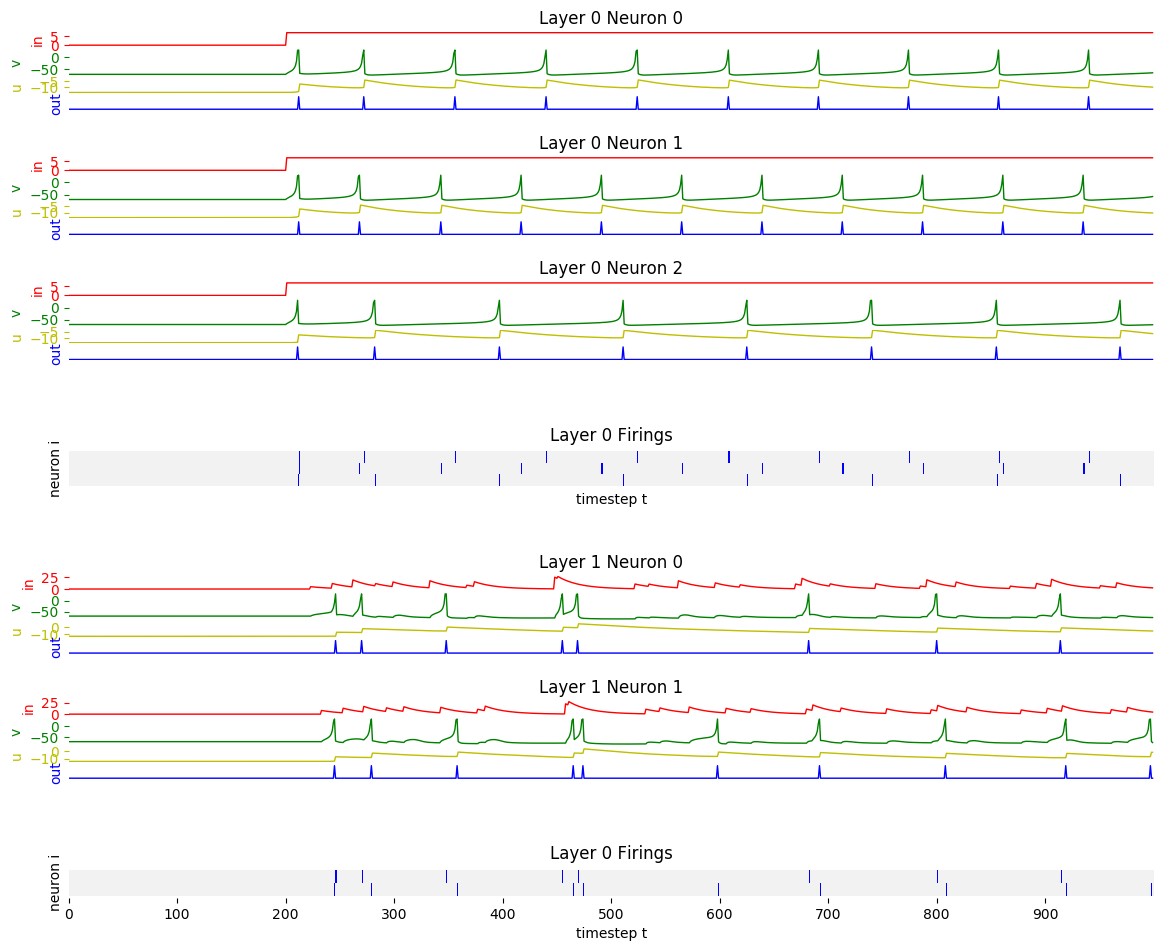

In [5]:
neuron_layer_0_traces = np.array([r['n0'] for r in traces])
neuron_layer_1_traces = np.array([r['n1'] for r in traces])

render_figure([IzhikevichNeuronTraceRenderer(neuron_layer_0_traces, 'Layer 0 Neuron'),
               NeuronFiringsRenderer(neuron_layer_0_traces[:,3,:], 30, 'Layer 0 Firings'),
               IzhikevichNeuronTraceRenderer(neuron_layer_1_traces, 'Layer 1 Neuron'), 
               NeuronFiringsRenderer(neuron_layer_1_traces[:,3,:], 30,'Layer 0 Firings')],
              1000, 2000, 100)